## Setup

In [ ]:
pip install 

In [ ]:
import json, time, pathlib
import matplotlib.pyplot as plt
import concurrent.futures

from pprint import pprint

import sklearn.datasets
import sklearn.metrics
from sklearn.inspection import plot_partial_dependence, permutation_importance

import autosklearn.classification

import concurrent.futures
import time

import sys, os

sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))

from AutoSklearn.with_ensemble import with_ensemble_experiment
from AutoSklearn.without_ensemble import without_ensemble_experiment


## Load Dataset

In [ ]:
dataset_name = 'mnist_784'

X, y = sklearn.datasets.fetch_openml(name=dataset_name, version=1, return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=1
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((52500, 784), (52500,), (17500, 784), (17500,))

## Experiments Parameters

In [ ]:
time_limit = 60 * 5  # 60 * número de minutos
tmp_path = pathlib.Path('../results/tmp/' + dataset_name)

## Experiments Functions

Iniciando experimento COM ensemble...
Iniciando experimento SEM ensemble...


COM ensemble concluído!
SEM ensemble concluído!
Todos os experimentos concluídos em 294.78 segundos


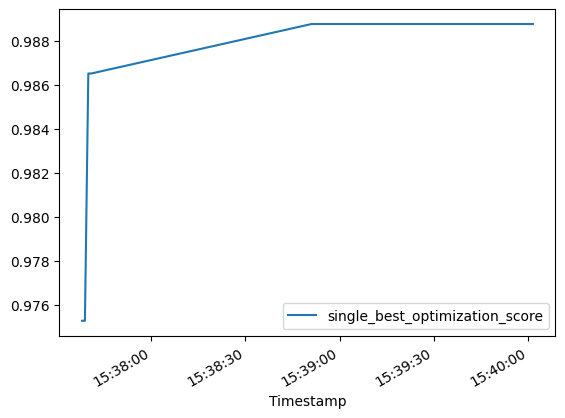

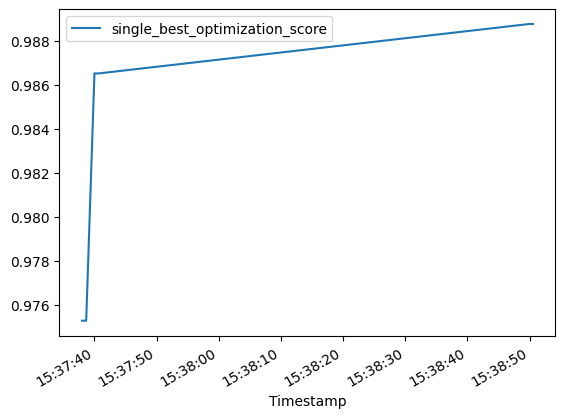

In [12]:
start_time = time.time()

results = {}

def process_result(experiment_name, automl_model):
    """Processa o resultado quando a thread termina"""
    print(f"{experiment_name} concluído!")
    
    predictions = automl_model.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    
    results[experiment_name] = {
        'model': automl_model,
        'accuracy': accuracy,
        'predictions': predictions
    }

    df = automl_model.performance_over_time_
    df.plot(x='Timestamp', y='single_best_optimization_score', kind='line')
    
    with open('../results/results.txt', 'a') as f:
        if experiment_name == 'COM ensemble':
            f.write(f"{dataset_name} - With ensemble:\n")
        else:
            f.write(f"{dataset_name} - Without ensemble:\n")
        f.write(f"Accuracy score: {accuracy}\n")
        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        f.write(f"Finished in: {minutes}m and {seconds}s\n\n")

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    print("Iniciando experimento COM ensemble...")
    future_with = executor.submit(
        with_ensemble_experiment, 
        X_train, y_train, time_limit, dataset_name, tmp_path / 'with_ensemble'
    )
    
    print("Iniciando experimento SEM ensemble...")
    future_without = executor.submit(
        without_ensemble_experiment, 
        X_train, y_train, time_limit, dataset_name, tmp_path / 'without_ensemble'
    )
    
    for future in concurrent.futures.as_completed([future_with, future_without]):
        if future == future_with:
            automl_with_ensemble = future.result()
            process_result("COM ensemble", automl_with_ensemble)
        else:
            automl_without_ensemble = future.result()
            process_result("SEM ensemble", automl_without_ensemble)

total_time = time.time() - start_time
print(f"Todos os experimentos concluídos em {total_time:.2f} segundos")

In [13]:
for result in results:
    print(f"Resultado para {result} teve acurácia de {results[result]['accuracy']:.2f}")
    print("Construção do modelo:")
    print(results[result]['model'].leaderboard(sort_by='cost'))
    print()


Resultado para COM ensemble teve acurácia de 0.99
Construção do modelo:
          rank  ensemble_weight                 type      cost  duration
model_id                                                                
19           1             0.02           libsvm_svc  0.011236  1.064847
4            2             0.04           libsvm_svc  0.013483  0.920067
24           3             0.14           libsvm_svc  0.013483  0.884224
59           4             0.02           libsvm_svc  0.015730  0.878790
7            5             0.02   passive_aggressive  0.017978  8.000868
14           6             0.04  k_nearest_neighbors  0.020225  0.945806
2            7             0.02        random_forest  0.024719  2.298819
16           8             0.02    gradient_boosting  0.033708  7.547254
33           9             0.08  k_nearest_neighbors  0.035955  1.104663
31          10             0.02        liblinear_svc  0.038202  1.206321
35          11             0.04           libsvm_svc

In [14]:
for result in results:
    print(f"Resultado para {result} teve acurácia de {results[result]['accuracy']:.2f}")
    print("Construção do modelo:")
    pprint(results[result]['model'].show_models(), indent=4)
    print()


Resultado para COM ensemble teve acurácia de 0.99
Construção do modelo:
{   2: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x744c74cde070>,
           'cost': 0.024719101123595544,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x744c882a13d0>,
           'ensemble_weight': 0.02,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x744c74cdeac0>,
           'model_id': 2,
           'rank': 1,
           'sklearn_classifier': RandomForestClassifier(max_features=7, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)},
    4: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x744c806a9670>,
           'cost': 0.01348314606

## Explaining the models

In [15]:
dataset = sklearn.datasets.fetch_openml("iris", version=1)
r = permutation_importance(automl_with_ensemble, X_test, y_test, n_repeats=10, random_state=0)
sort_idx = r.importances_mean.argsort()[::-1]

plt.boxplot(
    r.importances[sort_idx].T, labels=[dataset.feature_names[i] for i in sort_idx]
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(
        f"{dataset.feature_names[i]:10s}: {r.importances_mean[i]:.3f} +/- "
        f"{r.importances_std[i]:.3f}"
    )

KeyboardInterrupt: 

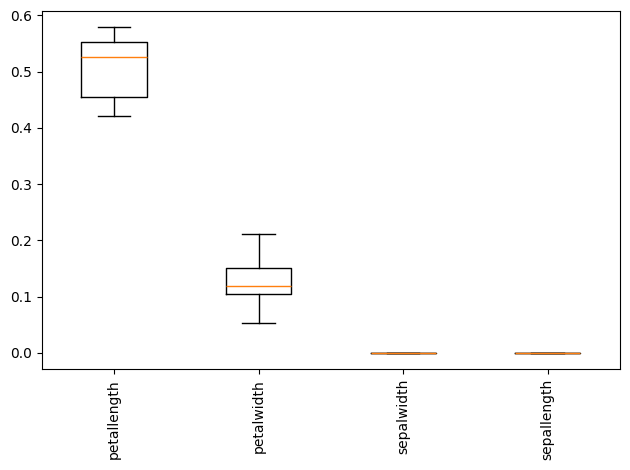

sepallength: 0.000 +/- 0.000
sepalwidth: 0.000 +/- 0.000
petalwidth: 0.126 +/- 0.045
petallength: 0.505 +/- 0.057


In [ ]:
r = permutation_importance(automl_without_ensemble, X_test, y_test, n_repeats=10, random_state=0)
sort_idx = r.importances_mean.argsort()[::-1]

plt.boxplot(
    r.importances[sort_idx].T, labels=[dataset.feature_names[i] for i in sort_idx]
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(
        f"{dataset.feature_names[i]:10s}: {r.importances_mean[i]:.3f} +/- "
        f"{r.importances_std[i]:.3f}"
    )

## Lista de próximas etapas:

- Verificar informações dos modelos de pre processamento

- Testar com outros datasets (mnist e wine quality dataset)

- Testar o imdb com mais tempo para estourar o teto

- Melhorar estrutura para salver os resultados dos exprimentos com mais métricas as e os gráficos

### Outros tópicos

- Pesquisar sobre SHAP e interpretabilidade
- Começar a usar o TPOT ou H2O